<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 30px;">   
   <strong> Deep Learning in Finance MAP548 -  Tutorial 3 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Deep pricing and calibration  </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>


In [3]:
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick

plt.rcParams["figure.figsize"] = (4.8, 3.2)
import urllib
import os
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

from math import exp, sqrt, log, pi, sin, cos, atan, tan
import math
import cmath
from cmath import exp as cexp
from cmath import sqrt as csqrt
from cmath import log as clog
from cmath import phase as phase
from cmath import polar as polar

from functools import partial
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.model_selection import train_test_split

import scipy
from scipy import optimize, stats
from scipy.optimize import minimize

from random import gauss, uniform
from tqdm.notebook import tqdm

from scipy.special import gamma as gamma_func
import mpmath as mp  # with special hypergeometric functions
from scipy.special import hyp2f1 as hyp_2f1

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
import gzip

warnings.filterwarnings("ignore")  # to suppress warning messages
import itertools

In [3]:
# xi,eta,kappa,rho
def print_params(x):
    print(
        "xi = " + str(x[0]),
        "\n",
        "eta = " + str(x[1]),
        "\n",
        "kappa = " + str(x[2]),
        "\n",
        "rho = " + str(x[3]),
        "\n",
    )

# Simulate the option payoffs (prices) for the params in the 1FactorTrainSet

In [13]:
S0 = 100
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]) * S0
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

In [6]:
raw_data = np.load(gzip.GzipFile("Bergomi1FactorTrainSet.txt.gz", "r"))
print(raw_data.shape)
X = raw_data[:, :4]
target_y = raw_data[:, 4:]
print("X shape:", X.shape)
print("Y shape:", target_y.shape)
# 4 params + 88 option prices (11 prices for each 8 maturities slice by slice starting from shortest maturity:)

(40000, 92)
X shape: (40000, 4)
Y shape: (40000, 88)


In [7]:
# print parameters
print_params(X[101])

xi = 0.087991 
 eta = 3.65226 
 kappa = 4.72152 
 rho = -0.620345 



In [11]:
def gen_bm_path(n_steps, N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

In [12]:
def path_generator(xi, kappa1, eta1, rho, T, n_steps, N_sims, S0, w1, w2):
    dt = T / n_steps
    tt = np.linspace(0.0, T, n_steps + 1)

    # Simulate Xt1
    exp1 = np.exp(kappa1 * tt[1:])
    exp2 = np.exp(2 * kappa1 * tt)
    diff_exp2 = np.diff(exp2)
    std_vec = (
        eta1 * np.sqrt(diff_exp2 / (2 * kappa1))[:, np.newaxis]
    )  # to be broadcasted columnwise
    exp1 = exp1[:, np.newaxis]
    Xt1 = np.concatenate(
        (
            np.zeros(w1.shape[1])[np.newaxis, :],
            (1 / exp1) * np.cumsum(std_vec * w1, axis=0),
        )
    )

    Xt = Xt1

    # Simulate Vt
    drift = eta1**2 * (1 - np.exp(-2 * kappa1 * tt)) / (2 * kappa1)
    Vt = xi * np.exp(Xt - 0.5 * drift[:, np.newaxis])

    # Simulate St
    log_S = np.ones(N_sims).reshape(1, -1) * log(S0)
    # epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
    for j in range(n_steps):
        log_S_next = (
            log_S[j]
            - 0.5 * Vt[j] * dt
            + np.sqrt(Vt[j] * dt) * (rho * w1[j] + sqrt(1 - rho**2) * w2[j])
        )
        log_S = np.append(log_S, log_S_next.reshape(1, -1), axis=0)

    S = np.exp(log_S)
    return S

In [11]:
def simulation(
    w1,
    w2,
    xi,
    kappa1,
    eta1,
    rho,
    n_steps: int = 1000,
    N_sims: int = 1000,
) -> np.ndarray:

    S0 = 100
    T = 2
    S = np.zeros((n_steps + 1, N_sims))

    # Define the strikes relative to S0
    strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]) * S0
    maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

    option_prices = np.zeros((len(strikes), len(maturities)))

    S = path_generator(xi, kappa1, eta1, rho, T, n_steps, N_sims, S0, w1, w2)
    option_prices = np.array(
        [
            np.mean(
                np.maximum(
                    0,
                    (S[int(maturity / T * n_steps), :][None, :] - strikes[:, None]),
                ),
                axis=1,
            )
            for maturity in maturities
        ]
    )
    return option_prices.flatten()

In [15]:
n_steps = 1000
N_sims = 1000
np.random.seed(42)
w1 = gen_bm_path(n_steps, N_sims)
np.random.seed(111)
w2 = gen_bm_path(n_steps, N_sims)
sim_res = []
for params in X[:1000]:
    xi, eta, kappa, rho = params
    option_prices = simulation(w1, w2, xi, kappa, eta, rho)
    sim_res.append(option_prices)
sim_res = np.array(sim_res)
sim_res.shape

In [46]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar


def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    option_price = np.exp(r * T) * (
        S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    )
    return option_price


def find_risk_free_rate(S, K, T, option_price, sigma):
    # Objective function to find the root of
    def objective(r):
        diffs = np.abs(black_scholes_call(S, K, T, r, sigma) - option_price)
        return diffs

    # Use minimize scaler method to find the root of the objective function
    res = minimize_scalar(objective, bounds=(0, 1), method="bounded")
    return res.x

# Try and reverse engineer the risk free rate

In [71]:
for i in range(88):
    print(
        "predicted risk free rate:",
        rate := find_risk_free_rate(
            100, strikes[i % 11], maturities[i // 11], sim_res[0, i], target_y[0, i]
        ),
    )
    print(
        "predicted option price:",
        black_scholes_call(
            100, strikes[i % 11], maturities[i // 11], rate, target_y[0, i]
        ),
    )
    print("actual option price:", sim_res[0, i])

predicted risk free rate: 5.9608609865491405e-06
predicted option price: 50.00005969098779
actual option price: 49.632053532837176
predicted risk free rate: 5.9608609865491405e-06
predicted option price: 40.00006444989952
actual option price: 39.632053532837176
predicted risk free rate: 5.9608609865491405e-06
predicted option price: 30.00031080493664
actual option price: 29.632053532837173
predicted risk free rate: 5.9608609865491405e-06
predicted option price: 20.011135690672592
actual option price: 19.641331800232518
predicted risk free rate: 5.9608609865491405e-06
predicted option price: 10.288588318120174
actual option price: 9.907370760514555
predicted risk free rate: 5.9608609865491405e-06
predicted option price: 2.9087471270650367
actual option price: 2.702474523636185
predicted risk free rate: 5.9608609865491405e-06
predicted option price: 0.35628466530488173
actual option price: 0.3285300700406717
predicted risk free rate: 6.09008923867266e-06
predicted option price: 0.0271602

In [59]:
rate_diffs = []
for rate in np.linspace(0, 0.05, 1000):
    diffs = []
    for i in range(sim_res.shape[1]):
        estimated_values = black_scholes_call(
            100, strikes[i % 11], maturities[i // 11], rate, target_y[:1000, i]
        )
        diff = np.mean(np.abs(estimated_values - sim_res[:, i]))
        diffs.append(diff)
    diffs = np.array(diffs)
    rate_diffs.append(diffs)
rate_diffs = np.array(rate_diffs)

In [77]:
np.argmin(rate_diffs, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Across all the different rates, r=0 seems to match the best with our prices. This is because we are treating the payoff at time T as the option price in this case

# Use this Rate R to find the implied vols of all the option payoffs(prices)

In [190]:
S0 = 100
data = []
for file in flist:
    some_data = np.load(f"{path}/{file}")
    data.append(some_data)
raw_data = np.concatenate(data, axis=0)
raw_data = np.delete(raw_data, np.unique(np.where(raw_data[:, 5:] == 0)[0]), 0)
X = raw_data[:, :5]
target_y = raw_data[:, 5:]
print("X shape:", X.shape)
print("Y shape:", target_y.shape)
# 4 params + 88 option prices (11 prices for each 8 maturities slice by slice starting from shortest maturity:)
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]) * S0
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

X shape: (115454, 5)
Y shape: (115454, 88)


In [ ]:
import scipy.stats as sps

In [ ]:
def Black_Scholes_function(t, S, T, K, r, sigma):
    """
    flag : boolean, flag = 1 for a call option and flag = 0 for a put option
    """
    sigma_sqrt_time = sigma * np.sqrt(T - t)

    d_1 = (np.log(S / K) + r * (T - t)) / sigma_sqrt_time + 0.5 * sigma_sqrt_time
    d_2 = d_1 - sigma_sqrt_time

    # Black-Scholes call price and delta
    price = S * sps.norm.cdf(d_1) - K * np.exp(-r * (T - t)) * sps.norm.cdf(d_2)

    return price

In [159]:
def volImplCallCore_bisection(
    t, S, T, K, r, price, price_tol=1.0e-3, max_iter=50, a=0, b=2.0
):
    """
    Implied volatility of a put option with price = price, the other parameters being

    tau   : time to maturity
    K     : strike
    DF    : discount factor
    F     : underlying forward price

    Method: bisection over the interval [a, b].
    """
    min_price = Black_Scholes_function(t, S, T, K, r, a)
    max_price = Black_Scholes_function(t, S, T, K, r, b)

    ######################################################
    ## We check whether the given option price is actually
    ## between the initial bounds of the bisection method
    ######################################################
    check = (min_price < price) & (price < max_price)

    if check == False:
        return np.nan

    else:
        vol_min = a
        vol_max = b

        vol = (vol_min + vol_max) / 2
        mid_price = Black_Scholes_function(t, S, T, K, r, vol)

        stopping_rule = np.abs(mid_price - price)
        iterations = 0

        while (stopping_rule > price_tol) & (iterations < max_iter):
            iterations = iterations + 1

            if mid_price - price > 0:
                vol_max = vol
                vol = (vol_min + vol_max) / 2
            else:
                vol_min = vol
                vol = (vol_min + vol_max) / 2

            mid_price = Black_Scholes_function(t, S, T, K, r, vol)

            stopping_rule = np.abs(mid_price - price)

        return vol

In [ ]:
vec_vol = np.vectorize(volImplCallCore_bisection)

In [164]:
target_y.shape

(115454, 88)

In [176]:
calculated_vols_total = []
for i in range(target_y.shape[1]):
    print(i)
    col = vec_vol(0, 100, maturities[i // 11], strikes[i % 11], 0.0, target_y[:, i])
    calculated_vols_total.append(col)
calculated_vols_total = np.array(calculated_vols_total).T

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


In [178]:
calculated_vols_total.shape
# np.save("implied_vol_no_zero_options_same_brownian.npy", calculated_vols_total)

(115454, 88)

In [6]:
os.getcwd()

'/Users/aadhar/Downloads/deep_fin_proj_1'

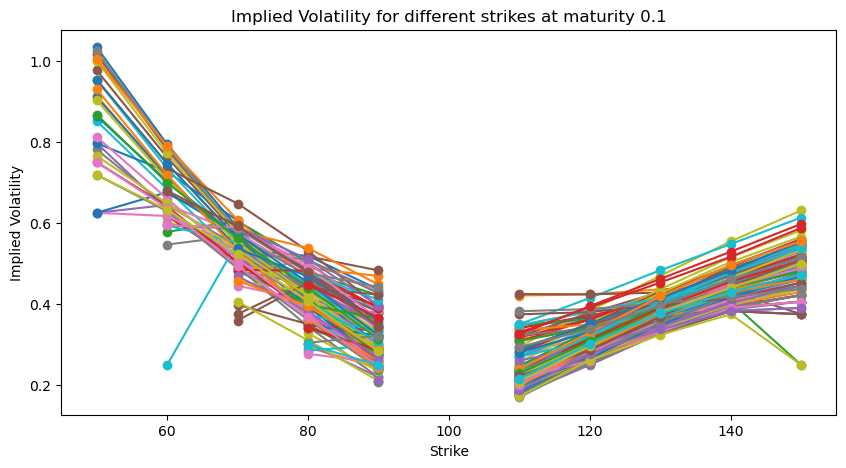

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(strikes, calculated_vols_total[:100, :11].T, marker="o")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility for different strikes at maturity 0.1")
plt.show()

We can see that none of the at the money implied vols have been calculated

In [682]:
np.isnan(calculated_vols_total).sum(axis=0)

array([ 86614,  76906,  43344,   4751,      0, 115454,      0,      0,
            0,      0,      0,  47683,  22314,   5160,    207,      0,
       115454,      0,      0,      0,      0,      0,  17760,   3181,
           80,      0,      0, 115454,      0,      0,      0,      0,
            0,  13393,    434,      0,      0,      0, 115454,      0,
            0,      0,      0,      0,  28139,   3093,     10,      0,
            0, 115454,      0,      0,      0,      0,      0,   3701,
           14,      0,      0,      0, 115454,      0,      0,      0,
            0,      0,    128,      0,      0,      0,      0, 115454,
            0,      0,      0,      0,      0,   2658,     36,      0,
            0,      0, 115454,      0,      0,      0,      0,      0])

## Rerun the impled vol calculator with larger values of a and b for columns with too many misssing vlaues for averagin to help

In [292]:
concerning_columns = np.where(np.isnan(calculated_vols_total).sum(axis=0) > 5000)

In [293]:
concerning_columns

(array([ 0,  1,  2,  5, 11, 12, 13, 16, 22, 27, 33, 38, 44, 49, 60, 71, 82]),)

In [685]:
for col in concerning_columns[0]:
    if col % 11 == 5:
        print(col)
        col_new = vec_vol(
            0,
            100,
            maturities[col // 11],
            strikes[col % 11],
            0.0,
            target_y[:, col],
            a=-20,
            b=100,
        )
        calculated_vols_total[:, col] = col_new

5
16
27
38
49
60
71
82


### Save all data where the full smile could be generated as 'golden_samples'

In [686]:
only_clean_data = np.delete(
    np.concatenate([X, calculated_vols_total], axis=1),
    np.unique(np.where(np.isnan(calculated_vols_total))[0]),
    0,
)

In [687]:
only_clean_data.shape

(20003, 93)

In [688]:
np.save("./deep_fin_proj_1/only_clean_data_same_brownian.npy", only_clean_data)

In [640]:
calculated_vols_total.shape

(115454, 88)

In [641]:
X.shape

(115454, 5)

For the remaining data, try and estimate the NaN values by fitting the smile to a parabola

In [825]:
def fit_remaining_vols_parabola(to_fit_vals):
    strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]) * 100
    indexes_to_guess = np.where(np.isnan(to_fit_vals))[0]
    indexes_to_guess.append(10)
    # indexes_to_guess = np.append(indexes_to_guess, 10)
    if len(indexes_to_guess) == 0:
        return to_fit_vals
    fitting_strikes = np.delete(strikes, indexes_to_guess)
    fitting_vals = np.delete(to_fit_vals, indexes_to_guess)

    fit = np.polyfit(fitting_strikes, fitting_vals, 2)
    polynome = np.poly1d(fit)
    to_fit_vals[indexes_to_guess] = polynome(strikes[indexes_to_guess])
    return to_fit_vals

In [826]:
new_calc_vol = calculated_vols_total.copy()
it = 0
for mat in range(8):
    print(it)
    for j, i in enumerate(calculated_vols_total[:, 11 * mat : 11 * (mat + 1)]):
        new_calc_vol[j, (11 * mat) : 11 * (mat + 1)] = fit_remaining_vols_parabola(i)
    it += 1

0
1
2
3
4
5
6
7


In [827]:
new_calc_vol = np.concatenate([X, new_calc_vol], axis=1)

In [828]:
graphing_vols = new_calc_vol[:, 5:]

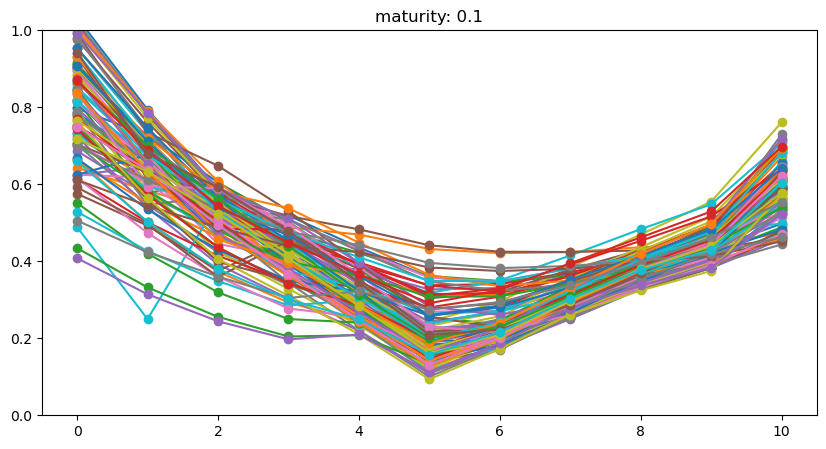

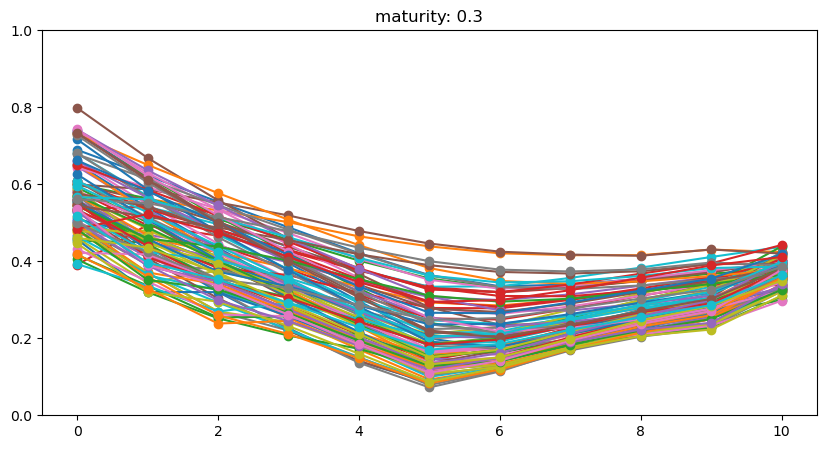

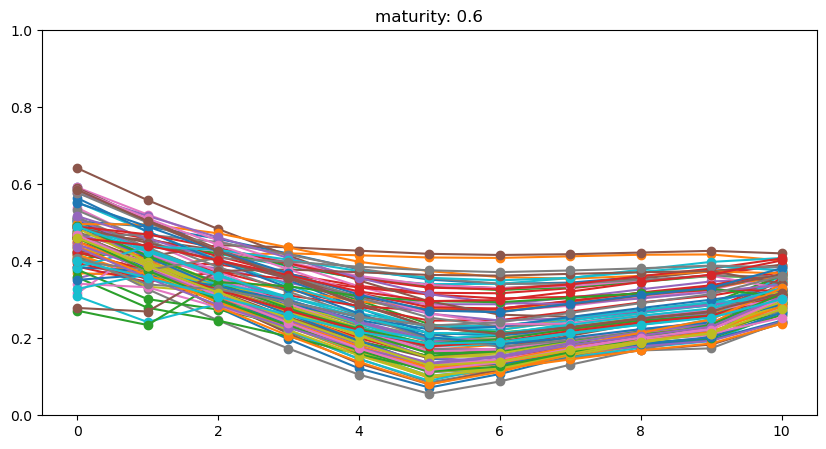

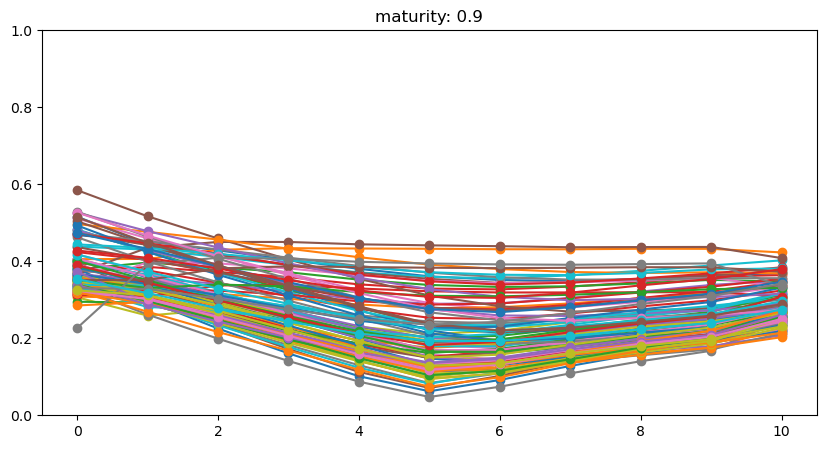

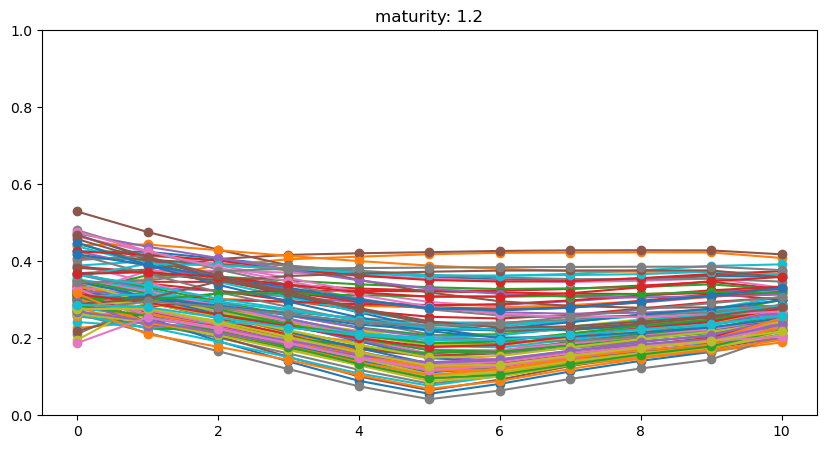

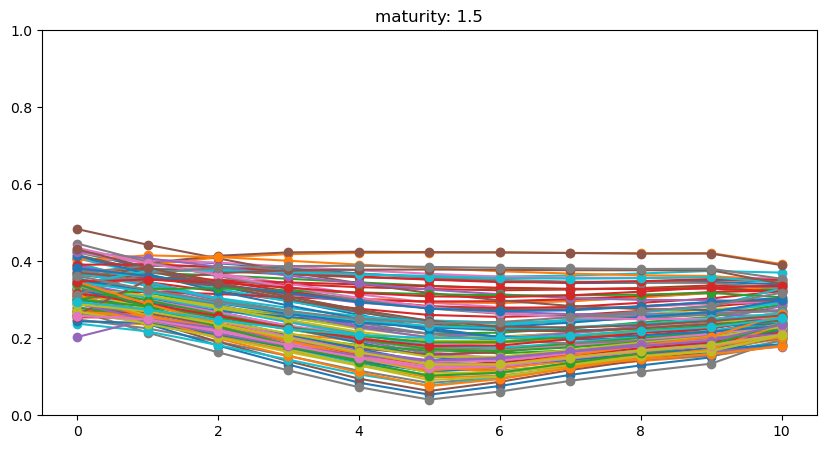

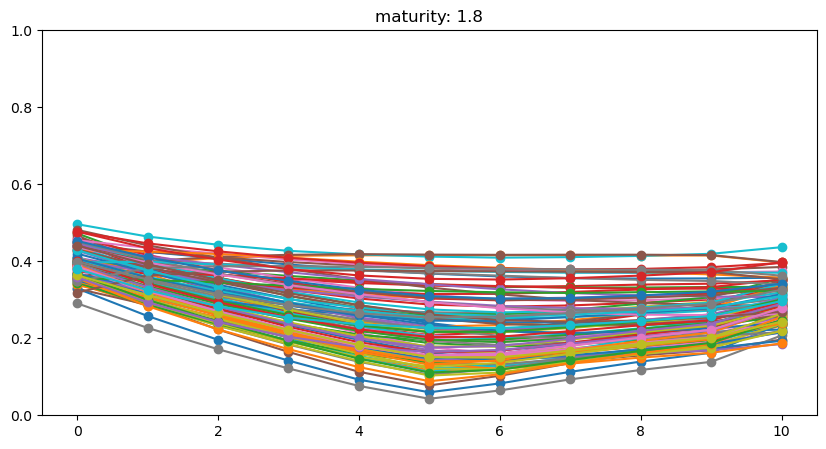

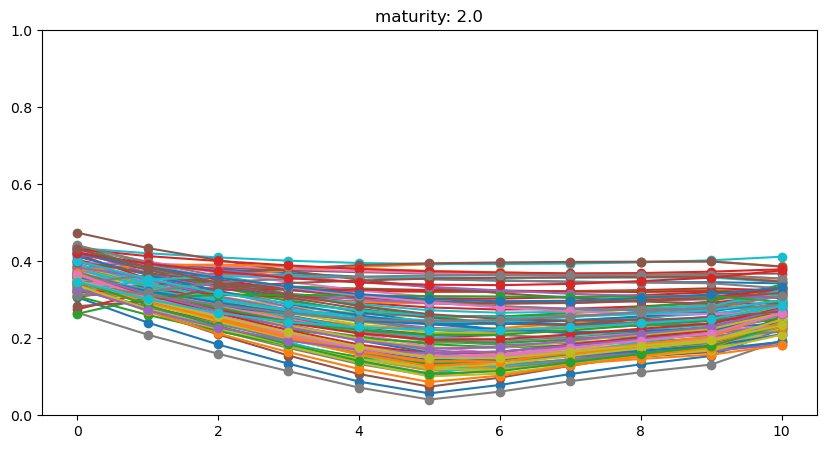

In [829]:
for i in range(8):
    plt.figure(figsize=(10, 5))
    plt.plot(
        graphing_vols[:100, i * 11 : (i + 1) * 11].T,
        marker="o",
    )
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.title(f"maturity: {maturities[i]}")
    plt.show()

In [830]:
# calculate the std of each of the columns
stds = np.std(graphing_vols, axis=0)
means = np.mean(graphing_vols, axis=0)

In [831]:
new_calc_final = np.delete(
    new_calc_vol, np.unique(np.where((np.abs(graphing_vols - means) > 3 * stds))[0]), 0
)

In [832]:
new_calc_final.shape

(109316, 93)

In [833]:
graphing_ncf = new_calc_final[:, 5:]
graphing_ncf.shape

(109316, 88)

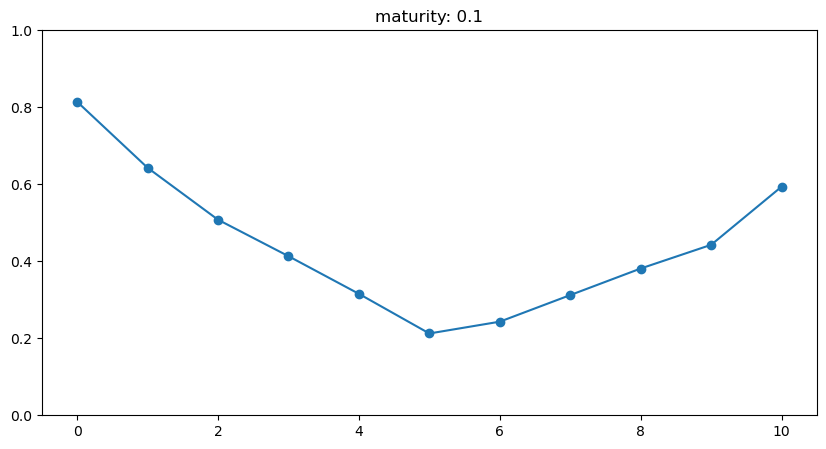

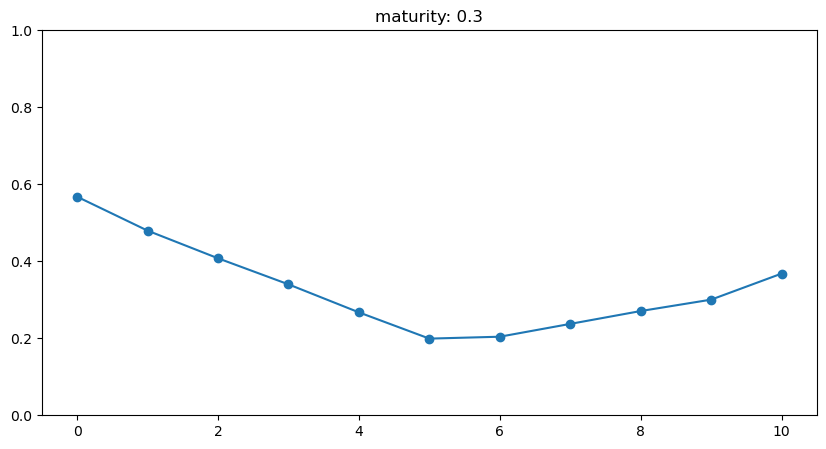

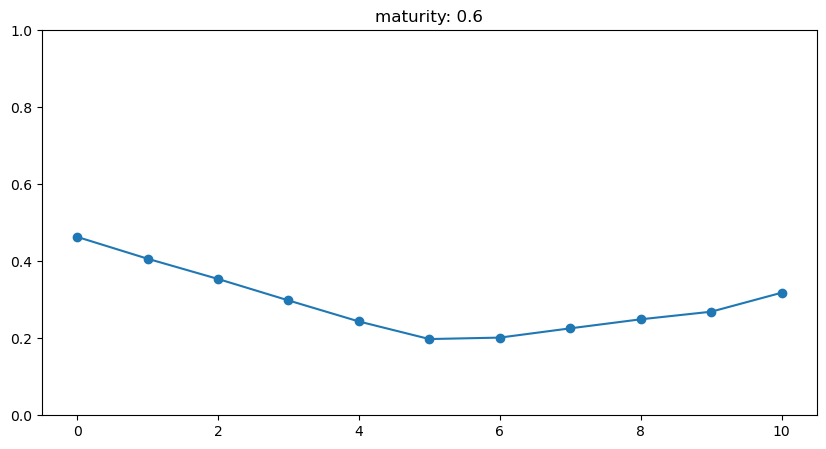

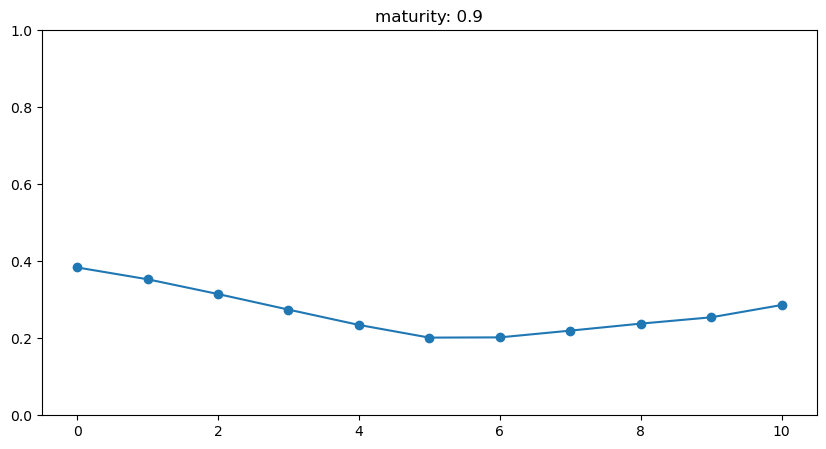

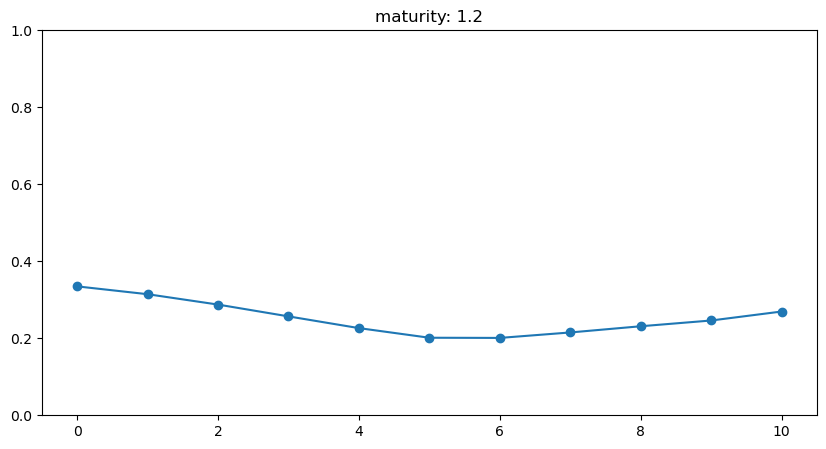

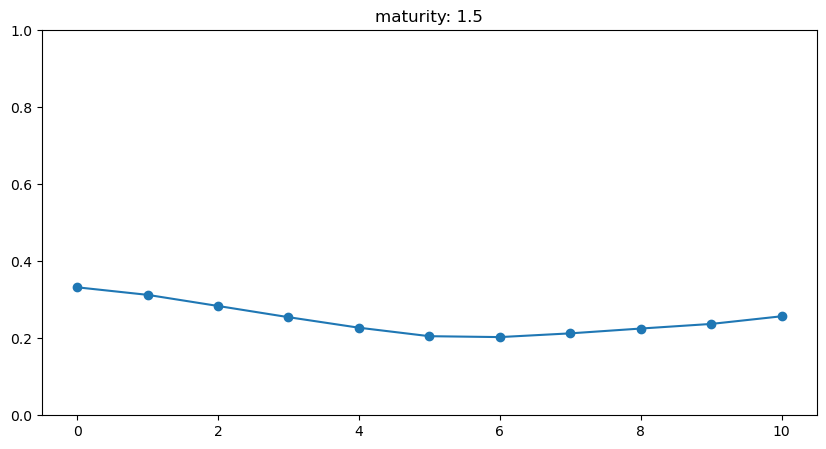

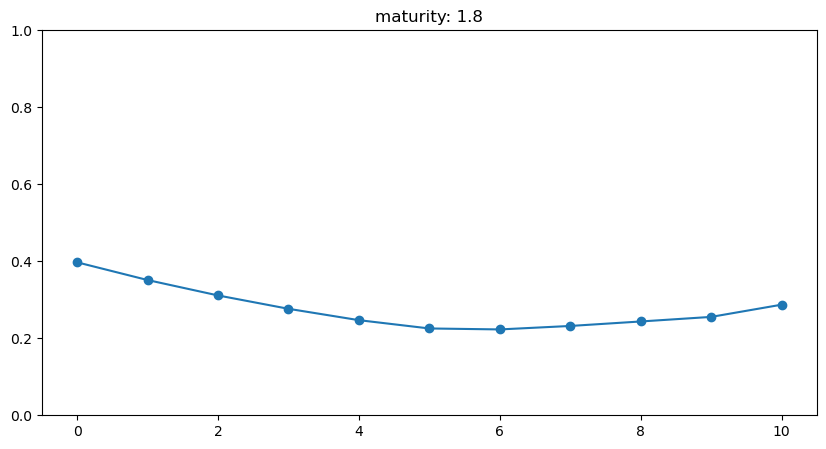

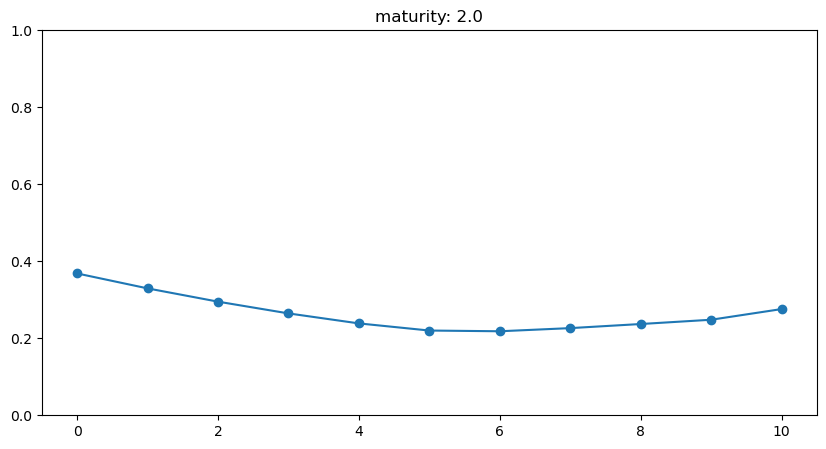

In [834]:
for i in range(8):
    plt.figure(figsize=(10, 5))
    plt.plot(
        np.mean(graphing_ncf[:100, i * 11 : (i + 1) * 11].T, axis=1),
        marker="o",
    )
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.title(f"maturity: {maturities[i]}")
    plt.show()

In [814]:
np.save(
    "./deep_fin_proj_1/cleaned_data_with_tail_sim.npy",
    new_calc_final,
)